In [1]:
# Generic imports:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math, random, re
import time
import pickle
from Bio import SeqIO
import multiprocessing
import glob
import os

In [2]:
# Machine learning/Stats imports:
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras import regularizers
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Dropout, Activation, Bidirectional, RepeatVector, Reshape, LSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class OnehotEmbedding2D(Layer):
    '''
    This is an alternative to the normal keras embedding layer
    which works on categorical data. This provides the same functionality
    but on a onehot encoding of the categorical data.
    '''
    def __init__(self, Nembeddings, **kwargs):
        self.Nembeddings = Nembeddings
        super(OnehotEmbedding2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[2], self.Nembeddings),
                                      initializer='uniform',
                                      trainable=True)
        super(OnehotEmbedding2D, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.Nembeddings)


In [4]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

# V genes:
V_GENE_LIST = ['TCRBV01-01', 'TCRBV02-01', 'TCRBV03-01', 'TCRBV03-02', 'TCRBV04-01', 'TCRBV04-02', 'TCRBV04-03',
               'TCRBV05-01', 'TCRBV05-02', 'TCRBV05-03', 'TCRBV05-04', 'TCRBV05-05', 'TCRBV05-06', 'TCRBV05-07',
               'TCRBV05-08', 'TCRBV06-01', 'TCRBV06-04', 'TCRBV06-05', 'TCRBV06-06', 'TCRBV06-07', 'TCRBV06-08',
               'TCRBV06-09', 'TCRBV07-01', 'TCRBV07-02', 'TCRBV07-03', 'TCRBV07-04', 'TCRBV07-05', 'TCRBV07-06',
               'TCRBV07-07', 'TCRBV07-08', 'TCRBV07-09', 'TCRBV08-02', 'TCRBV09-01', 'TCRBV10-01', 'TCRBV10-02',
               'TCRBV10-03', 'TCRBV11-01', 'TCRBV11-02', 'TCRBV11-03', 'TCRBV12-01', 'TCRBV12-02', 'TCRBV12-05',
               'TCRBV13-01', 'TCRBV14-01', 'TCRBV15-01', 'TCRBV16-01', 'TCRBV18-01', 'TCRBV19-01', 'TCRBV20-01',
               'TCRBV21-01', 'TCRBV22-01', 'TCRBV23-01', 'TCRBV23-or09_02', 'TCRBV25-01', 'TCRBV27-01', 'TCRBV28-01',
               'TCRBV29-01', 'TCRBV30-01', 'TCRBVA-or09_02']
V_GENE_DICT = {c:i for i, c in enumerate(V_GENE_LIST)}
V_GENE_DICT_REV = {i:c for i, c in enumerate(V_GENE_LIST)}
V_GENE_SET = set(V_GENE_LIST)

# J genes:
J_GENE_LIST = ['TCRBJ01-01', 'TCRBJ01-02', 'TCRBJ01-03', 'TCRBJ01-04', 'TCRBJ01-05', 'TCRBJ01-06', 'TCRBJ02-01',
               'TCRBJ02-02', 'TCRBJ02-03', 'TCRBJ02-04', 'TCRBJ02-05', 'TCRBJ02-06', 'TCRBJ02-07']
J_GENE_DICT = {c:i for i, c in enumerate(J_GENE_LIST)}
J_GENE_DICT_REV = {i:c for i, c in enumerate(J_GENE_LIST)}
J_GENE_SET = set(J_GENE_LIST)

In [5]:
try:
    import jellyfish
    def hamming_distance(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(s1, s2)
except:
    def hamming_distance(seq1, seq2):
        '''Hamming distance between two sequences of equal length'''
        return sum(x != y for x, y in zip(seq1, seq2))

In [6]:
def TCRbeta2onehot(TCRB_list):
    '''
    Translate a list of TCR betas into onehot encodings.
    NB. all CDR3 sequences must be of equal length.
    '''
    seqlen = len(TCRB_list[0][0])
    assert(not [True for s in TCRB_list if len(s[0]) != seqlen])
    onehot_seq = np.zeros((len(TCRB_list), seqlen, len(AA_SET)))
    onehot_vgene = np.zeros((len(TCRB_list), len(V_GENE_SET)))
    onehot_jgene = np.zeros((len(TCRB_list), len(J_GENE_SET)))
    for i, el in enumerate(TCRB_list):
        seq, vgene, jgene = el
        onehot_vgene[i][V_GENE_DICT[vgene]] = 1
        onehot_jgene[i][J_GENE_DICT[jgene]] = 1
        for j, a in enumerate(seq):
            onehot_seq[i][j][AA_DICT[a]] = 1
    return(onehot_seq, onehot_vgene, onehot_jgene)

In [7]:
def onehot2TCRbeta(onehot_seq, onehot_vgene, onehot_jgene):
    '''
    Convert back from onehot encodings to TCR betas.
    '''
    TCRB_list = list()
    for i in range(onehot_seq.shape[0]):
        seq = list()
        for j in range(onehot_seq.shape[1]):
            seq.append(AA_DICT_REV[onehot_seq[i][j].argmax()])
        seq = ''.join(seq)
        vgene = V_GENE_DICT_REV[onehot_vgene[i].argmax()]
        jgene = J_GENE_DICT_REV[onehot_jgene[i].argmax()]
        TCRB_list.append((seq, vgene, jgene))
    return(TCRB_list)

In [111]:
# Read in some sequences:
MAX_SEQS = 100000
MAX_LEN = 30
# fnam = '02-0249_TCRB_KD_cut.tsv'
fnam = 'all_TCRB_KD_cut.tsv'
#fnam = 'HIP13427_KD_cut.tsv'
TCRB_list = list()
for i, line in enumerate(open(fnam, 'r')):
    if i >= MAX_SEQS:
        break
    rows = line.strip().split()
    seq = str(rows[1])
    if len(seq) > MAX_LEN:
        continue
    else:  # Pad the middle with gaps
        pad_start = len(seq) // 2
        N_pad = MAX_LEN - len(seq)
        seq = seq[ :pad_start] + '-' * N_pad + seq[pad_start: ]
        assert(len(seq) == MAX_LEN)
        TCRB_list.append((seq, rows[2], rows[3]))

print('Input data has {} sequences.'.format(len(TCRB_list)))
print('This is how a typical TCR beta looks:\n{}'.format(TCRB_list[0]))

Input data has 100000 sequences.
This is how a typical TCR beta looks:
('CAAAA--------------------AEAFF', 'TCRBV30-01', 'TCRBJ01-01')


In [112]:
# Transform to onehot:
onehot_CDR3, onehot_Vgene, onehot_Jgene = TCRbeta2onehot(TCRB_list)

In [95]:
# Various network definitions:
batch_size = 100
input_shape = [inp.shape[1:] for inp in (onehot_CDR3, onehot_Vgene, onehot_Jgene)]
input_total_dim = sum([np.array(shape).prod() for shape in input_shape])

embedding_output_dim = [10, 10, 5]
# embedding_output_dim = [21, 59, 13]  # Equal to no embedding
latent_dim = 20
dense_nodes = 100

epsilon_std = 1.0
def sampling(args):
    '''This function draws a sample from the multinomial defined by the latent variables.'''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

def vae_loss(io_encoder, io_decoder):
    '''The loss function is the sum of the cross-entropy and KL divergence.'''
    # Notice that "objectives.categorical_crossentropy(io_encoder, io_decoder)"
    # is a vector so it is averaged using "K.mean":
    xent_loss = io_decoder.shape.num_elements() * K.mean(objectives.categorical_crossentropy(io_encoder, io_decoder))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss *= 1 / 3 * batch_size  # Because we have three input/output
    return(xent_loss + kl_loss)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 59)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

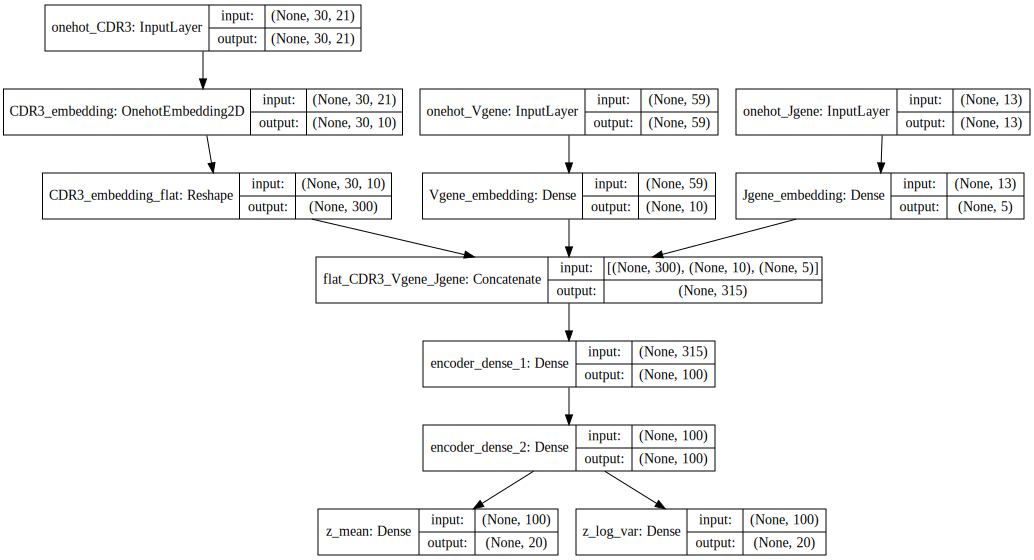

In [96]:
# Encoding layers:
encoder_input_CDR3 = Input(shape=input_shape[0], name='onehot_CDR3')
encoder_input_Vgene = Input(shape=input_shape[1], name='onehot_Vgene')
encoder_input_Jgene = Input(shape=input_shape[2], name='onehot_Jgene')

embedding_CDR3 = OnehotEmbedding2D(embedding_output_dim[0], name='CDR3_embedding')(encoder_input_CDR3)
AA_embedding = Model(encoder_input_CDR3, embedding_CDR3)
embedding_CDR3_flat = Reshape([embedding_output_dim[0] * MAX_LEN], name='CDR3_embedding_flat')(embedding_CDR3)
embedding_Vgene = Dense(embedding_output_dim[1], name='Vgene_embedding')(encoder_input_Vgene)
Vgene_embedding = Model(encoder_input_Vgene, embedding_Vgene)
embedding_Jgene = Dense(embedding_output_dim[2], name='Jgene_embedding')(encoder_input_Jgene)
Jgene_embedding = Model(encoder_input_Jgene, embedding_Jgene)


merged_input = keras.layers.concatenate([embedding_CDR3_flat, embedding_Vgene, embedding_Jgene], name='flat_CDR3_Vgene_Jgene')
dense_encoder1 = Dense(dense_nodes, activation='elu', name='encoder_dense_1')(merged_input)
dense_encoder2 = Dense(dense_nodes, activation='elu', name='encoder_dense_2')(dense_encoder1)

# Latent layers:
z_mean = Dense(latent_dim, name='z_mean')(dense_encoder2)
z_log_var = Dense(latent_dim, name='z_log_var')(dense_encoder2)

encoder = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [z_mean, z_log_var])
encoder.summary()
# plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
decoder_dense_1 (Dense)          (None, 100)           2100        input_4[0][0]                    
                                                                   input_4[0][0]                    
                                                                   input_4[0][0]                    
____________________________________________________________________________________________________
decoder_dense_2 (Dense)          (None, 100)           10100       decoder_dense_1[3][0]            
                                                                   decoder_dense_1[4][0]   

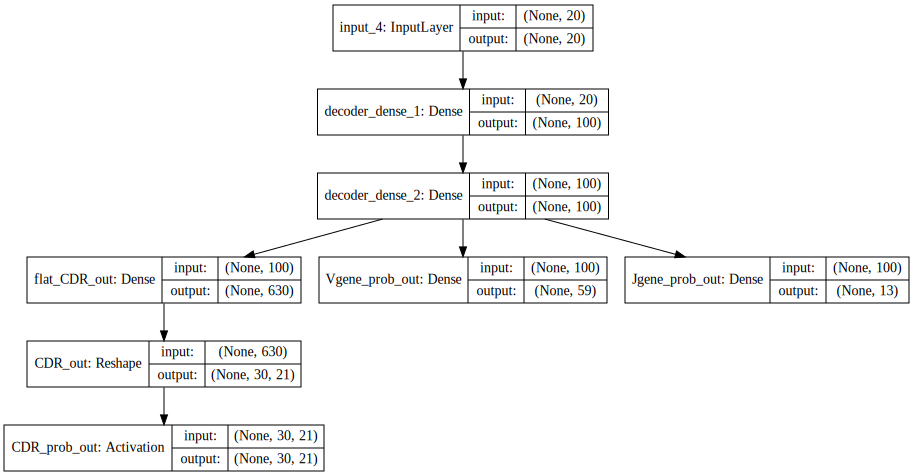

In [97]:
# Decoding layers:
z = Lambda(sampling, output_shape=(latent_dim, ), name='reparameterization_trick')  # This is the reparameterization trick
dense_decoder1 = Dense(dense_nodes, activation='elu', name='decoder_dense_1')
dense_decoder2 = Dense(dense_nodes, activation='elu', name='decoder_dense_2')

decoder_out_CDR3 = Dense(np.array(input_shape[0]).prod(), activation='linear', name='flat_CDR_out')
reshape_CDR3 = Reshape(input_shape[0], name='CDR_out')
position_wise_softmax_CDR3 = Activation(activation='softmax', name='CDR_prob_out')
decoder_out_Vgene = Dense(input_shape[1][0], activation='softmax', name='Vgene_prob_out')
decoder_out_Jgene = Dense(input_shape[2][0], activation='softmax', name='Jgene_prob_out')

decoder_output_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))))
decoder_output_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))
decoder_output_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))

# Define the decoding part separately:
z_mean_generator = Input(shape=(latent_dim,))
decoder_generator_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z_mean_generator)))))
decoder_generator_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z_mean_generator)))
decoder_generator_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z_mean_generator)))

decoder = Model(z_mean_generator, [decoder_generator_CDR3, decoder_generator_Vgene, decoder_generator_Jgene])
decoder.summary()
# plot_model(decoder, to_file='decoder.svg', show_shapes=True)
SVG(model_to_dot(decoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 59)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

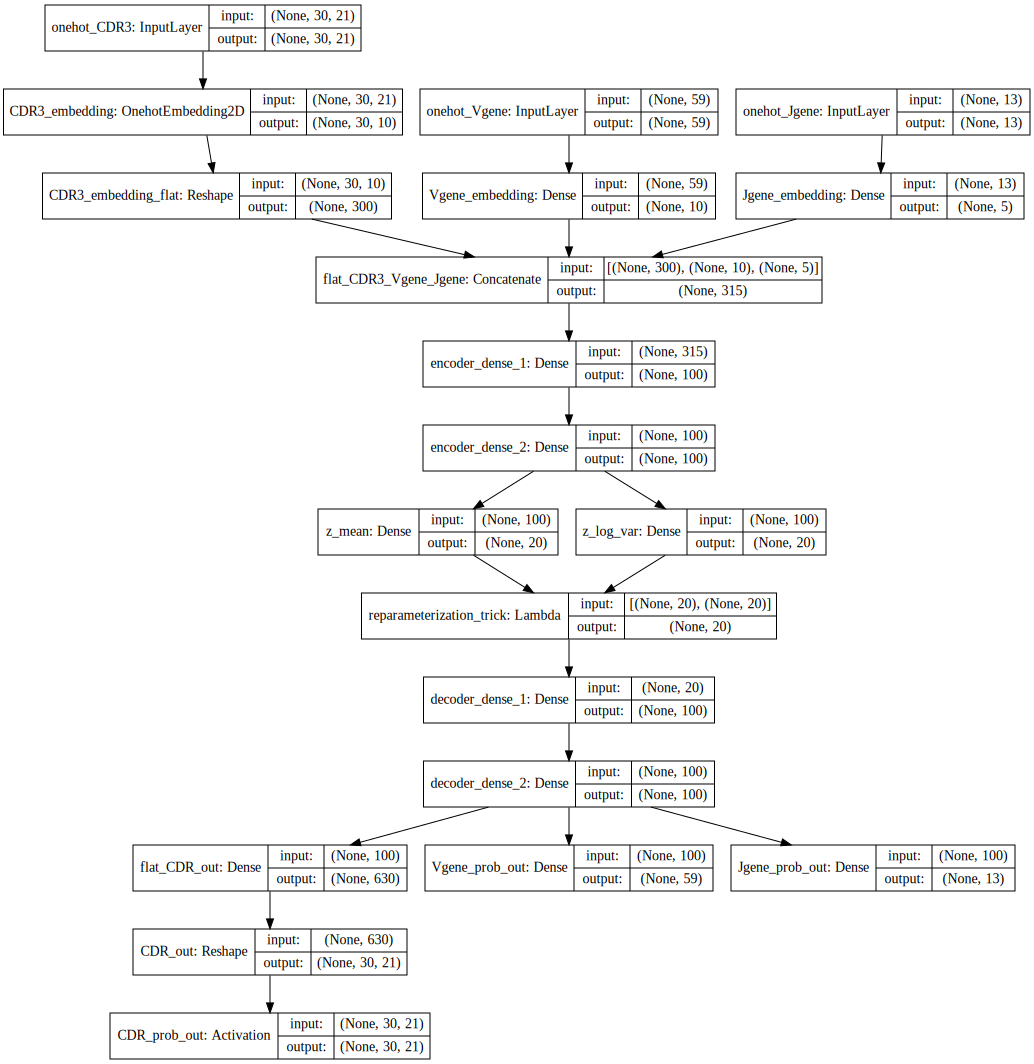

In [98]:
vae = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [decoder_output_CDR3, decoder_output_Vgene, decoder_output_Jgene])
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()
#vae.save('two_layer_vae_TCR_init.h5')
plot_model(vae, to_file='vae_TCR.svg', show_shapes=True)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [113]:
# Shuffle the data:
perm_idxs = np.random.permutation(onehot_CDR3.shape[0])
onehot_CDR3 = np.take(onehot_CDR3, perm_idxs, axis=0)
onehot_Vgene = np.take(onehot_Vgene, perm_idxs, axis=0)
onehot_Jgene = np.take(onehot_Jgene, perm_idxs, axis=0)

# Split dataset into train/test:
sl = len(onehot_CDR3) // (batch_size*100)
onehot_CDR3 = onehot_CDR3[:(sl*batch_size*100)]
onehot_Vgene = onehot_Vgene[:(sl*batch_size*100)]
onehot_Jgene = onehot_Jgene[:(sl*batch_size*100)]

In [114]:
test_fraction = 0.1
test_size = int(test_fraction * len(onehot_CDR3))
train_size = len(onehot_CDR3) - test_size
train_mask = np.array([True]*train_size + [False]*test_size)
np.random.shuffle(train_mask)
test_mask = train_mask == False
assert(sum(train_mask*test_mask) == 0)

In [115]:
x_train_CDR3 = onehot_CDR3[train_mask]
x_test_CDR3 = onehot_CDR3[test_mask]
x_train_Vgene = onehot_Vgene[train_mask]
x_test_Vgene = onehot_Vgene[test_mask]
x_train_Jgene = onehot_Jgene[train_mask]
x_test_Jgene = onehot_Jgene[test_mask]

In [116]:
use_cache = True
nb_epoch = 300
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
best_weights_filename = "cached_weights_TCR_vae/two_layer_dense_vae-TCR_weights_best.h5"
if not (use_cache and os.path.isfile(best_weights_filename)):
    save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vae_log = vae.fit([x_train_CDR3, x_train_Vgene, x_train_Jgene],
                      [x_train_CDR3, x_train_Vgene, x_train_Jgene],  # VAE is unsupervised so y=X
                      shuffle=True,
                      epochs=nb_epoch,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[early_stopping, save_best_weights])
vae.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

In [117]:
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [118]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = vae.evaluate(x=[x_train_CDR3, x_train_Vgene, x_train_Jgene], y=[x_train_CDR3, x_train_Vgene, x_train_Jgene], batch_size=batch_size)
testset_loss = vae.evaluate(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], y=[x_test_CDR3, x_test_Vgene, x_test_Jgene], batch_size=batch_size)
print('\nComponent-wise loss Train vs. Test:')
for i in [1, 2, 3]:
    print('{}: {:.2f} vs. {:.2f}'.format(vae.metrics_names[i], float(trainset_loss[i]), float(testset_loss[i])))
print('# Sum of losses #\nTrain set: {:.2f}\nTest set: {:.2f}'.format(float(trainset_loss[0]), float(testset_loss[0])))

 9900/10000 [============================>.] - ETA: 0s
Component-wise loss Train vs. Test:
CDR_prob_out_loss: 2715.42 vs. 2720.80
Vgene_prob_out_loss: 1398.56 vs. 1407.90
Jgene_prob_out_loss: 1361.25 vs. 1358.13
# Sum of losses #
Train set: 5475.23
Test set: 5486.83


In [119]:
# Encode a chunk of testset data into latent space:
chunk = 10000
x_test_encoded = encoder.predict([x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk]])
print('Output shape: [{}, {}]'.format(x_test_encoded[0].shape, x_test_encoded[0].shape))

Output shape: [(10000, 20), (10000, 20)]


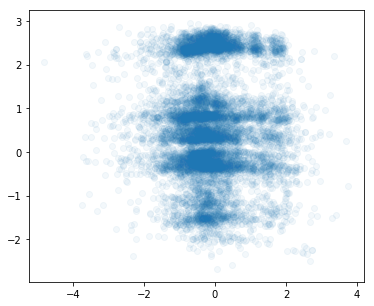

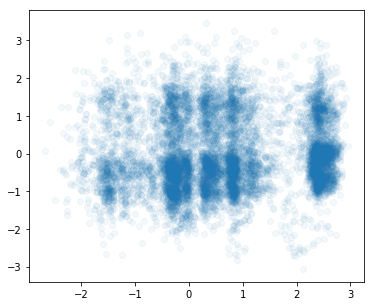

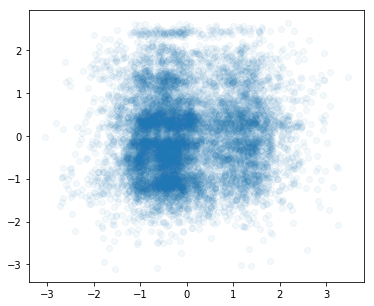

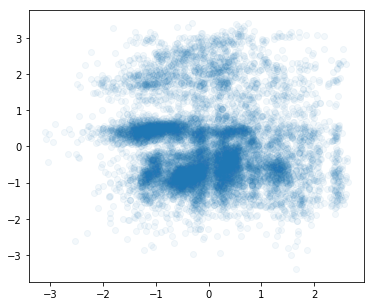

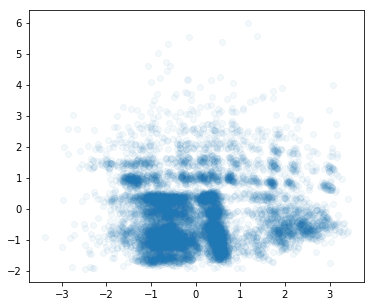

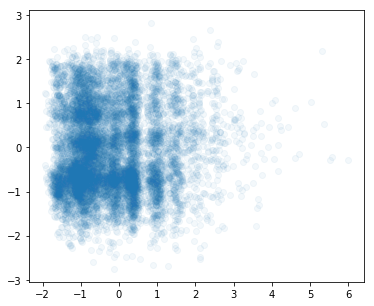

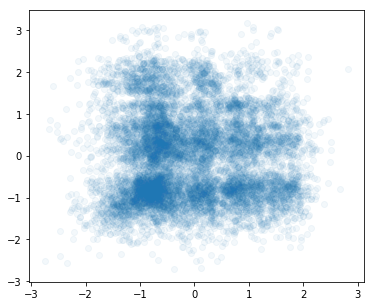

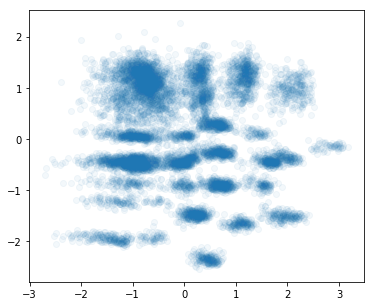

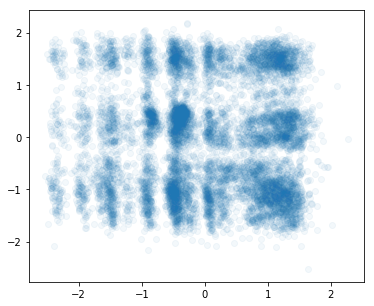

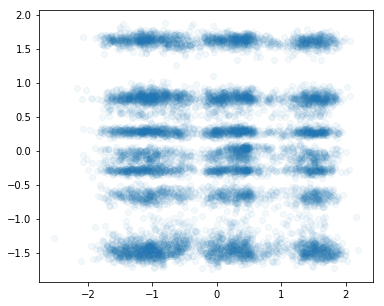

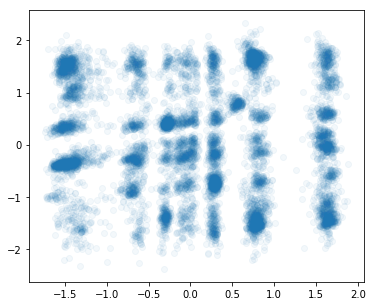

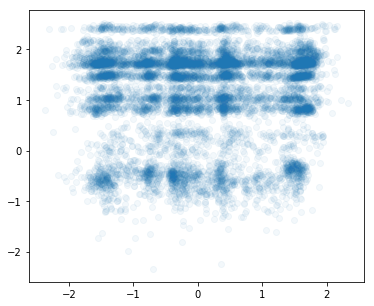

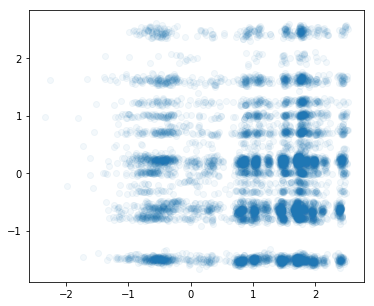

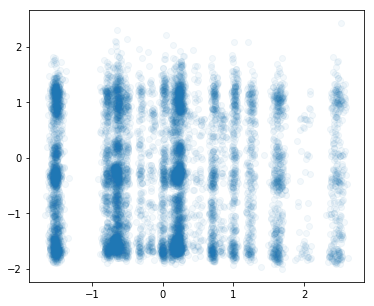

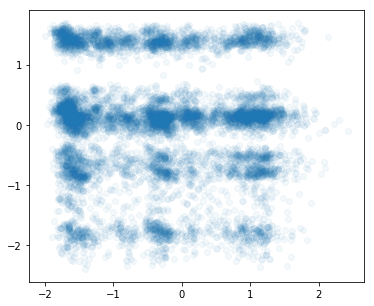

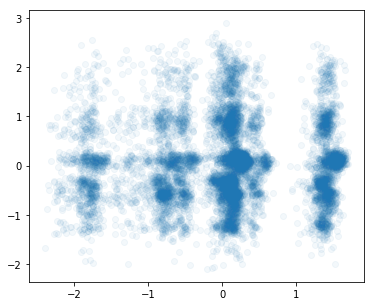

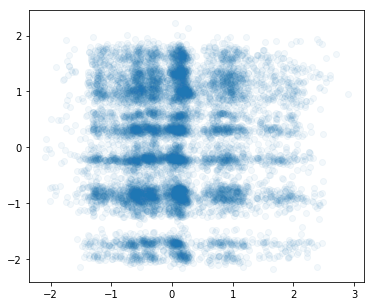

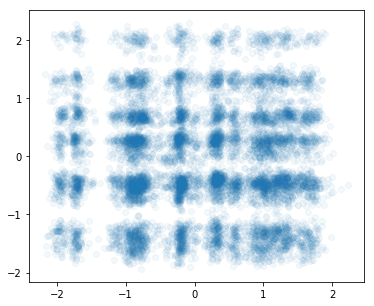

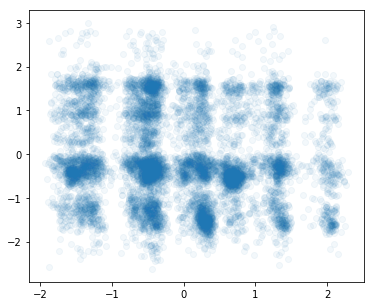

In [120]:
# Take a quick look at the latent space:
for i in range(19):
    x = list(x_test_encoded[0][:, i])
    y = list(x_test_encoded[0][:, i+1])
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.05);

In [121]:
# Do a PCA to see how much explained variance that can be extracted
# from any two dimensional combination of the latent space:
pca = PCA(n_components=2)
pca.fit(x_test_encoded[0])
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 18.1%


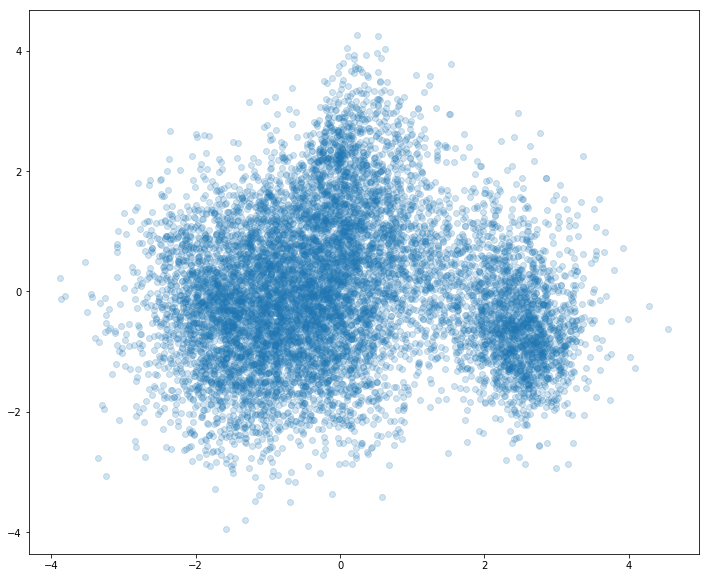

In [122]:
# Plot the PCA results:
X_r = pca.fit(x_test_encoded[0]).transform(x_test_encoded[0])
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=0.2);

In [123]:
# Decode the chunk of testdata from latent space into the original input space:
x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded = decoder.predict(x_test_encoded[0])

In [124]:
# The softmax activation on the last layer should bound the sum of each position to 1.
# This enable us to intepret the values as probabilities.
print('The sum of character probabilities at position one is: {}'.format(str(sum(x_test_CDR3_decoded[0][0]))))
print('The sum of probabilities at all {} positions is: {}'.format(str(x_test_CDR3_decoded.shape[1]), str(sum(sum(x_test_CDR3_decoded[0])))))

The sum of character probabilities at position one is: 1.0000000000000027
The sum of probabilities at all 30 positions is: 29.99999987407928


In [125]:
# Then translate the onehot encoding to a sequence:
TCRb_test = onehot2TCRbeta(x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk])
TCRb_test_decoded = onehot2TCRbeta(x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded)

In [126]:
# Compare the input sequences with those that have been a roundtrip through the VAE:
mismatches = 0
print('First line is the input sequence.\nSecond line is the VAE output.\nThird line is the amino acid identity for the input sequence in case of disagreements.\nFourth line is the amino acid identity for the VAE output in case of disagreements.\n')
for i in range(100):
    y = list(TCRb_test[i][0]) + [' ']*5 + [TCRb_test[i][1]] + [' ']*5 + [TCRb_test[i][2]]
    p = list(TCRb_test_decoded[i][0]) + [' ']*5 + [TCRb_test_decoded[i][1]] + [' ']*5 + [TCRb_test_decoded[i][2]]
    print(''.join(y))
    print(''.join(p))
    print('{}'.format(''.join([' ' if i==j else '*'*len(i) for i,j in zip(y, p)])))
    print()
    mismatches += sum(0 if i==j else 1 for i,j in zip(y, p))
print('\nTotal disagreements: {}'.format(mismatches))

First line is the input sequence.
Second line is the VAE output.
Third line is the amino acid identity for the input sequence in case of disagreements.
Fourth line is the amino acid identity for the VAE output in case of disagreements.

CASGLGD----------------RVSEQYF     TCRBV07-02     TCRBJ02-07
CASGLGD----------------RVSEQYF     TCRBV07-02     TCRBJ02-07
                                          

CAISDSG---------------SSYNEQFF     TCRBV10-03     TCRBJ02-01
CAISDSG---------------SSYNEQFF     TCRBV10-03     TCRBJ02-01
                                          

CAISESM----------------GMYEQYF     TCRBV10-03     TCRBJ02-07
CAISESM----------------GMYEQYF     TCRBV10-03     TCRBJ02-07
                                          

CASKGGS----------------ANEKLFF     TCRBV04-01     TCRBJ01-04
CASKGGS----------------ANEKLFF     TCRBV04-01     TCRBJ01-04
                                          

CASKPGG----------------SYNEQFF     TCRBV05-01     TCRBJ02-01
CASKPGG----------------SYNEQFF     TCR

In [83]:
# Sample from the latent space to generate new TCR betas:
lsample = np.random.normal(0, 1, size=(batch_size * 10000, latent_dim))
vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene = decoder.predict(lsample)
vae_sample_TCRb = onehot2TCRbeta(vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene)

In [84]:
for i in range(100):
    y = list(vae_sample_TCRb[i][0]) + [' ']*5 + [vae_sample_TCRb[i][1]] + [' ']*5 + [vae_sample_TCRb[i][2]]
    print(''.join(y))

CASSWFA----------------GRNIQYF     TCRBV07-08     TCRBJ02-07
CSSSWQ------------------PNEAFF     TCRBV29-01     TCRBJ01-01
CASSYRD---------------LLNEPQHF     TCRBV19-01     TCRBJ01-05
CASSLYGS--------------RRKDEQFF     TCRBV06-05     TCRBJ02-01
CASSFYLD--------------LGNHEQYF     TCRBV28-01     TCRBJ02-07
CATMGSYP-------------MGGKNTIYF     TCRBV06-01     TCRBJ01-03
CASSQG-----------------RFGGYTF     TCRBV06-04     TCRBJ01-02
CASRRP-----------------QPNEQFF     TCRBV28-01     TCRBJ02-01
CASSADD---------------GRNKTQYF     TCRBV07-04     TCRBJ02-05
CASPLTA---------------GLRDTQYF     TCRBV25-01     TCRBJ02-05
CASSLT------------------NTEAFF     TCRBV19-01     TCRBJ01-01
CASSWGGL-------------TVFTDEQFF     TCRBV27-01     TCRBJ02-01
CASSRDM---------------GYSYELFF     TCRBV28-01     TCRBJ02-02
CASSGD-----------------SPHEQYF     TCRBV10-03     TCRBJ02-07
CASSLLS---------------GAGQPQHF     TCRBV07-07     TCRBJ01-05
CASSKVR---------------TSHYEAFF     TCRBV07-07     TCRBJ01-01
CASSW-------------------

In [85]:
with open('all_TCRB_KD_cut_predictions_HIP13427.tsv', 'w') as fh_out:
    for TCR in vae_sample_TCRb:
        TCR = list(TCR)
        TCR[0] = TCR[0].replace('-', '')
        s = '\t'.join(TCR)
        fh_out.write(s + '\n')

In [127]:
# Birthday paradox.
# Find identical randomly generated sequences to estimate the distribution size:
mult = 100000
with open('TCR_gen_1E9.txt', 'w') as fh_out:
    for i in range(100):
        print(i)
        bp_sample_z = np.random.normal(0, 1, size=(batch_size * mult, latent_dim))
        bp_sample_CDR3, bp_sample_Vgene, bp_sample_Jgene = decoder.predict(bp_sample_z)
        bp_sample_TCRb = onehot2TCRbeta(bp_sample_CDR3, bp_sample_Vgene, bp_sample_Jgene)

        for TCR in bp_sample_TCRb:
            TCR = list(TCR)
            TCR[0] = TCR[0].replace('-', '')
            s = '\t'.join(TCR)
            print(s, file=fh_out)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [149]:
# Calculate an estimated support of the generative distribution 
# using sample size and collision probability:
def S2N(S, p_hat):
    eps = 1  # Hyperparameter which is distribution-dependent
    N_approx = -1 * (S**2 * eps) / (2 * N * np.log(1 - p_hat))
    return(int(N_approx))

In [104]:
# To save space represent each unique sequence as a number,
# then one can sample from this list of numbers.
total_lines = int(1e9)  # Number of generated sequences in the non-deduplicated file
TCR_list = np.zeros(total_lines, dtype=np.int32)
with open('TCR_gen_1E9_counted.txt', 'r') as fh:
    counter = 0  # Sequences are named according to observation order
    for i, l in enumerate(fh):
        # This is the number of times the sequence was observed
        # in the original non-deduplicated file:
        N = int(l.split()[0])
        for _ in range(N):
            TCR_list[counter] = i
            counter += 1
np.random.shuffle(TCR_list)

In [151]:
# Use the list of sequence numbers for sampling to
# find the desired probability of at least one collision.

iterations = 1000  # Number of samples to estimate collision probability
max_slice_size = len(TCR_list)
min_slice_size = 1
# Start with a bottom-up search were the "min_slice_size" is increased
# by multiplication with this factor:
increaments = 10
binary_search = False  # Set to false from the start. Will swtich over by itself.
birthday_prob = 0.5    # The desired collision probability
precision = 0.01       # Stop when this precision of the "birthday_prob" has been reached
prob = 0.0             # Initial collision probability

while abs(prob - birthday_prob) >= precision or max_slice_size == min_slice_size:
    # After the bottom-up search to find a suitable "max_slice_size",
    # follow-up with binary search:
    if binary_search is False:
        slice_size = min_slice_size * increaments
    else:
        slice_size = (max_slice_size + min_slice_size) // 2

    # Run iterations to estimate the collision probability:
    prob = 0.0
    for _ in range(iterations):
        # Get a random index to make a random slice:
        idx = random.randint(0, total_lines)
        # Make the slice and handle exceptions
        # where the slice exceeds the length of the list:
        if (idx + slice_size) <= total_lines:
            sl = TCR_list[idx:(idx + slice_size)]
        else:
            sl1 = TCR_list[idx:total_lines]
            sl2 = TCR_list[0:(slice_size - len(sl1))]
            sl = np.concatenate([sl1, sl2])
        # Check for collisions:
        if len(np.unique(sl)) < slice_size:
            prob += 1
    prob /= iterations
    
    # If the collision probability is too high
    # a new "max_slice_size" has been found
    # and the search is switched to binary:
    if prob > birthday_prob:
        binary_search = True
        if slice_size < max_slice_size:
            max_slice_size = slice_size
            # print('New max:', max_slice_size)
    # Otherwise the "min_slice_size" should be moved upwards:
    else:
        if slice_size > min_slice_size and slice_size < max_slice_size:
            min_slice_size = slice_size
            # print('New min:', min_slice_size)
    print('\nAt slice size:', slice_size)
    print('Prob:', prob)

print('\nFinal slice size:', slice_size)
print('Given support size of:', S2N(slice_size, prob))


At slice size: 10
Prob: 0.0

At slice size: 100
Prob: 0.0

At slice size: 1000
Prob: 0.0

At slice size: 10000
Prob: 0.076

At slice size: 100000
Prob: 1.0

At slice size: 55000
Prob: 0.89

At slice size: 77500
Prob: 0.989

At slice size: 66250
Prob: 0.953

At slice size: 60625
Prob: 0.931

At slice size: 57812
Prob: 0.901

Final slice size: 57812
Given support size of: 722601431


In [ ]:
# p_hat = 0.5 -> 735620597
# p_hat = 0.1 -> 768407907
# p_hat = 0.9 -> 722601431

In [115]:
# Look at the embeddings:
onehot_Vgenes = np.zeros((batch_size, len(V_GENE_SET)))
Vgene_labels = list()
for vgene, idx in V_GENE_DICT.items():
    Vgene_labels.append(vgene)
    onehot_Vgenes[idx][idx] = 1

In [116]:
Vgenes_embedded = Vgene_embedding.predict(onehot_Vgenes)
Vgenes_embedded = Vgenes_embedded[:len(V_GENE_SET)]

In [117]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=1).fit(Vgenes_embedded)
cmap = kmeans.labels_

In [118]:
sorted([(kl, vgene) for kl, vgene in zip(kmeans.labels_, Vgene_labels)], key=lambda x: x[0])

[(0, 'TCRBV01-01'),
 (0, 'TCRBV06-04'),
 (0, 'TCRBV20-01'),
 (0, 'TCRBV29-01'),
 (1, 'TCRBV03-01'),
 (1, 'TCRBV03-02'),
 (1, 'TCRBV05-02'),
 (1, 'TCRBV06-07'),
 (1, 'TCRBV06-08'),
 (1, 'TCRBV06-09'),
 (1, 'TCRBV07-01'),
 (1, 'TCRBV08-02'),
 (1, 'TCRBV16-01'),
 (2, 'TCRBV06-05'),
 (2, 'TCRBV10-03'),
 (2, 'TCRBV15-01'),
 (2, 'TCRBV23-or09_02'),
 (2, 'TCRBV25-01'),
 (3, 'TCRBV22-01'),
 (4, 'TCRBV05-05'),
 (4, 'TCRBV06-01'),
 (4, 'TCRBV06-06'),
 (4, 'TCRBV07-02'),
 (4, 'TCRBV19-01'),
 (4, 'TCRBV27-01'),
 (4, 'TCRBV28-01'),
 (4, 'TCRBV30-01'),
 (5, 'TCRBV02-01'),
 (5, 'TCRBV04-02'),
 (5, 'TCRBV05-03'),
 (5, 'TCRBV05-08'),
 (5, 'TCRBV07-06'),
 (5, 'TCRBV10-02'),
 (5, 'TCRBV11-03'),
 (5, 'TCRBVA-or09_02'),
 (6, 'TCRBV04-01'),
 (6, 'TCRBV04-03'),
 (6, 'TCRBV05-01'),
 (6, 'TCRBV05-06'),
 (6, 'TCRBV11-02'),
 (6, 'TCRBV14-01'),
 (6, 'TCRBV18-01'),
 (7, 'TCRBV05-07'),
 (7, 'TCRBV07-03'),
 (7, 'TCRBV07-04'),
 (7, 'TCRBV07-08'),
 (7, 'TCRBV11-01'),
 (7, 'TCRBV12-02'),
 (7, 'TCRBV23-01'),
 (8, 'TCRBV

In [ ]:
fig = plt.figure(figsize=(12,12))

In [ ]:
# Plot V gene clusters:
plt.figure(figsize=(12, 10))

plt.scatter(x_train_encoded[:, z1][::-1], x_train_encoded[:, z2][::-1], c=cmap[::-1] ,alpha=1, marker="o");


In [119]:
# Do a PCA:
pca = PCA(n_components=2)
pca.fit(Vgenes_embedded)
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 47.6%


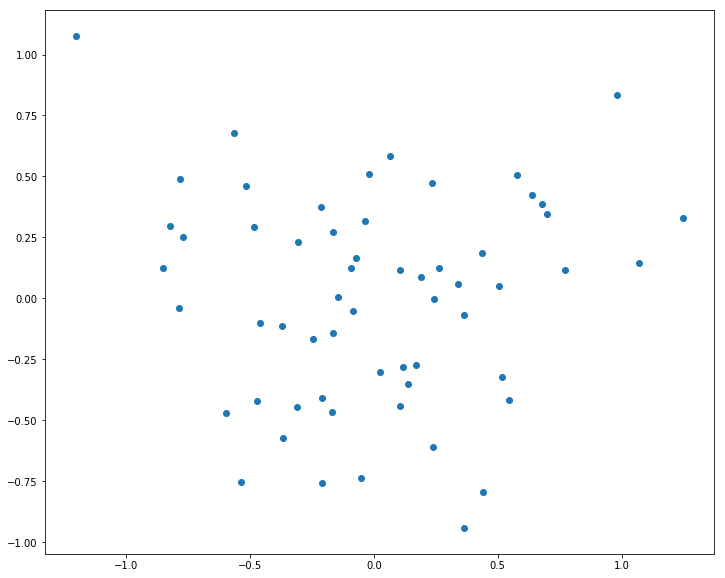

In [120]:
# Plot the PCA results:
X_r = pca.fit(Vgenes_embedded).transform(Vgenes_embedded)
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=1);

In [ ]:
# Load weights for 3D embedding of the amino acids i.e. from 21 dimensions into 3:
vae.load_weights("cached_weights_TCR_vae/two_layer_dense_vae-TCR_weights_best_3d_AAenc.h5")

In [191]:
# Look at the amino acid embeddings:
onehot_AA = np.zeros((batch_size, MAX_LEN, len(AA_SET)))
AA_labels = list()
for AA, idx in AA_DICT.items():
    AA_labels.append(AA)
    for j in range(MAX_LEN):
        onehot_AA[idx][j][idx] = 1
AA_embedded = AA_embedding.predict(onehot_AA)
AA_embedded = AA_embedded[:len(AA_SET)]
AA_embedded = np.array([AA_embedded[j][0] for j in range(len(AA_SET))])

In [192]:
# Cluster the amino acids based on their embedding:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=1).fit(AA_embedded)
cmap = kmeans.labels_
print(('Cluster', 'Amino acid'))
print(sorted([(kl, AA) for kl, AA in zip(kmeans.labels_, AA_labels)], key=lambda x: x[0]))

('Cluster', 'Amino acid')
[(0, 'A'), (0, 'F'), (0, 'G'), (0, 'R'), (0, 'S'), (0, 'V'), (0, '-'), (1, 'D'), (1, 'H'), (1, 'N'), (2, 'M'), (2, 'W'), (3, 'E'), (3, 'K'), (4, 'C'), (4, 'I'), (4, 'L'), (4, 'P'), (4, 'Q'), (4, 'T'), (4, 'Y')]


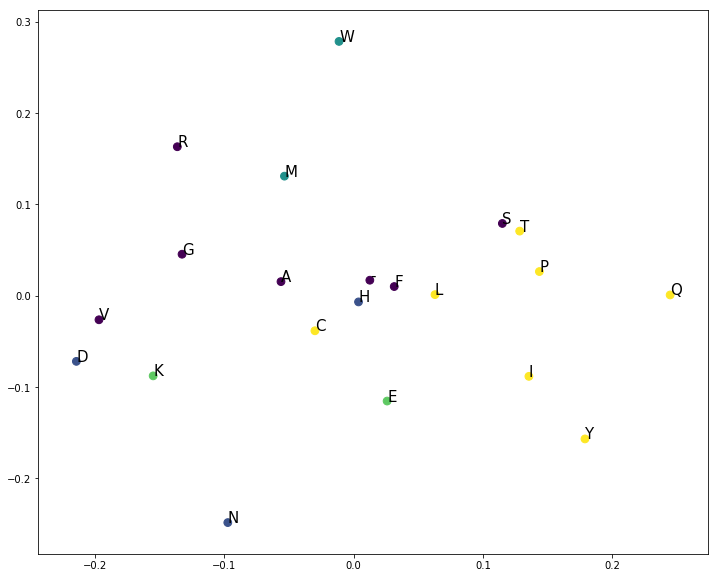

In [193]:
# Plot using PCA:
X_r = pca.fit(AA_embedded).transform(AA_embedded)
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=1, c=cmap, s=60);
for i, txt in enumerate(AA_labels):
    plt.annotate(txt, (x[i], y[i]), size=15)

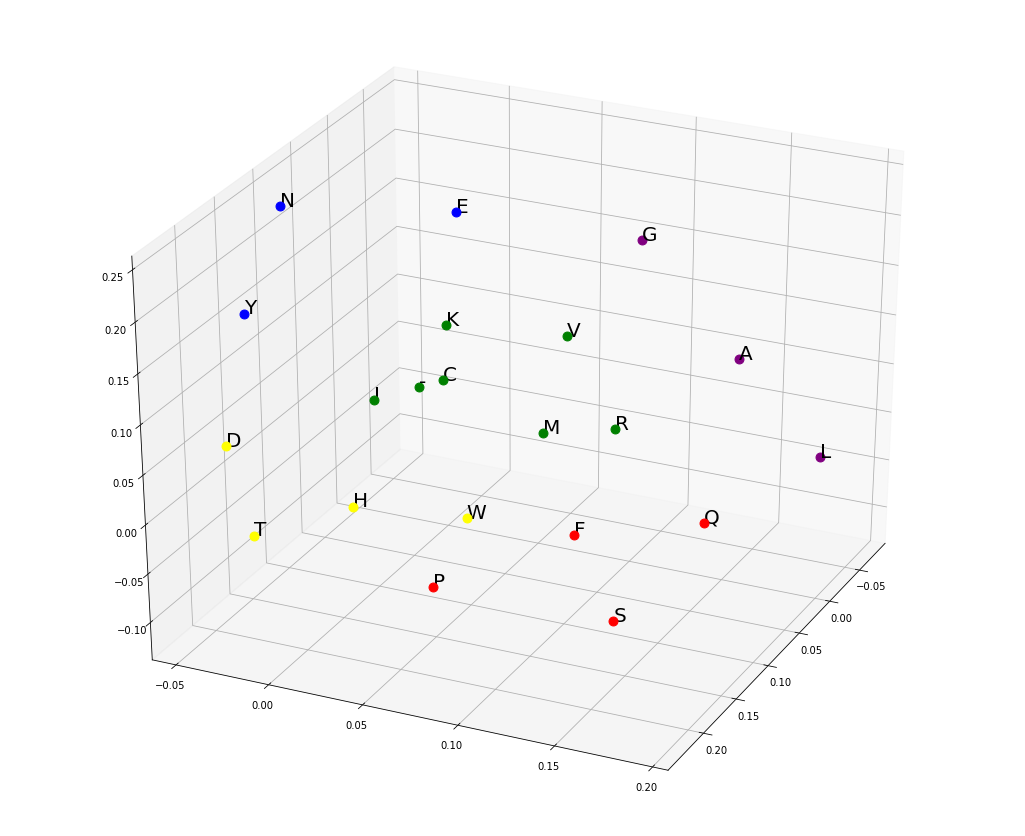

In [182]:
# Plot each amino acid into a 3D grid using the embeddings
# and color by cluster membership:
from mpl_toolkits.mplot3d import Axes3D
cmap_color = {0: 'r', 1: 'b', 2: 'g', 3: 'purple', 4: 'yellow'}
fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(111, projection='3d')
for i, p in enumerate(AA_embedded):
    x, y, z = p
    ax.scatter(x, y, z, s=80, c=cmap_color[cmap[i]])
    ax.text(x, y, z, AA_labels[i], size=20)
ax.view_init(azim=25)

In [ ]:
### ^Can't say that this makes much sense.

In [194]:
# Atchley factors:
af = {
'A': [-0.591,-1.302,-0.733,1.570,-0.146],
'C': [-1.343,0.465,-0.862,-1.020,-0.255],
'D': [1.050,0.302,-3.656,-0.259,-3.242],
'E': [1.357,-1.453,1.477,0.113,-0.837],
'F': [-1.006,-0.590,1.891,-0.397,0.412],
'G': [-0.384,1.652,1.330,1.045,2.064],
'H': [0.336,-0.417,-1.673,-1.474,-0.078],
'I': [-1.239,-0.547,2.131,0.393,0.816],
'K': [1.831,-0.561,0.533,-0.277,1.648],
'L': [-1.019,-0.987,-1.505,1.266,-0.912],
'M': [-0.663,-1.524,2.219,-1.005,1.212],
'N': [0.945,0.828,1.299,-0.169,0.933],
'P': [0.189,2.081,-1.628,0.421,-1.392],
'Q': [0.931,-0.179,-3.005,-0.503,-1.853],
'R': [1.538,-0.055,1.502,0.440,2.897],
'S': [-0.228,1.399,-4.760,0.670,-2.647],
'T': [-0.032,0.326,2.213,0.908,1.313],
'V': [-1.337,-0.279,-0.544,1.242,-1.262],
'W': [-0.595,0.009,0.672,-2.128,-0.184],
'Y': [0.260,0.830,3.097,-0.838,1.512]
}

In [196]:
# Use as dataframe for R:
# print(','.join(['x1', 'x2', 'x3', 'y1', 'y2', 'y3', 'y4', 'y5']))
print(','.join(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'y1', 'y2', 'y3', 'y4', 'y5']))
for i, p in enumerate(AA_embedded):
    aa = AA_labels[i]
    if aa in af:
        y = ','.join(map(str, af[aa]))
        x = ','.join(map(str, p))
        print(x+','+y)

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y1,y2,y3,y4,y5
-0.14638382,0.0004994061,0.1560728,-0.0012415827,-0.0002667144,0.054570727,-0.049052954,0.00065550976,-0.0016171152,0.0024499607,-0.591,-1.302,-0.733,1.57,-0.146
-0.0015690471,-0.0075267055,0.10989786,-0.02388546,-0.007202898,-0.019557983,0.08057563,0.0066250144,0.0068486435,0.18149751,-1.343,0.465,-0.862,-1.02,-0.255
-0.13498387,0.12291456,0.0056944983,-0.017078096,0.14875601,0.025697,0.0912271,-0.17608188,0.010638298,0.16393591,1.05,0.302,-3.656,-0.259,-3.242
0.122478366,-0.07871277,0.079844974,-0.010162686,0.09923857,0.06772874,-0.055431597,-0.086875945,-0.20181622,0.111025095,1.357,-1.453,1.477,0.113,-0.837
0.0012628449,-0.09417304,0.199659,0.1623053,-0.00046581356,-0.0047429265,-0.0050060176,-0.0036827235,-0.050456375,0.007327739,-1.006,-0.59,1.891,-0.397,0.412
-0.14627025,0.06925933,-0.022723248,-0.0351974,-0.035710055,0.005252592,0.08236058,0.0146711655,-0.18640622,0.0009113301,-0.384,1.652,1.33,1.045,2.064
-0.09546632,-0.05590744,-0

In [ ]:
### No good correlation between Atchley factors and amino acid embeddings.
### Also the amino acid embeddings cannot be used as a good predictor (via. linear modeling) of Atchley factors.